# 1. Problem Statement

# 2. Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set style for visualizations 
plt.style.use('ggplot')
sns.set_theme(style='whitegrid')

# Function to get latest processed data
def get_latest_processed_file(base_dir='../data/processed'):
    pattern = os.path.join(base_dir, 'processed_data_*.csv')
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No processed data files found in {base_dir}")
    # Get the most recent file based on timestamp in filename
    latest_file = max(files, key=lambda x: x.split('_')[-1].replace('.csv',''))
    return latest_file

# Read the data with error handling
try:
    # Get and load latest file
    latest_file = get_latest_processed_file()
    print(f"Loading data from: {os.path.basename(latest_file)}")
    
    # Read CSV and process dates
    df = pd.read_csv(latest_file)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    print(f"Data shape: {df.shape}")
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
except Exception as e:
    print(f"Unexpected error: {str(e)}")

Loading data from: processed_data_20241221.csv
Data shape: (235, 8)


Running Time Series Analysis...


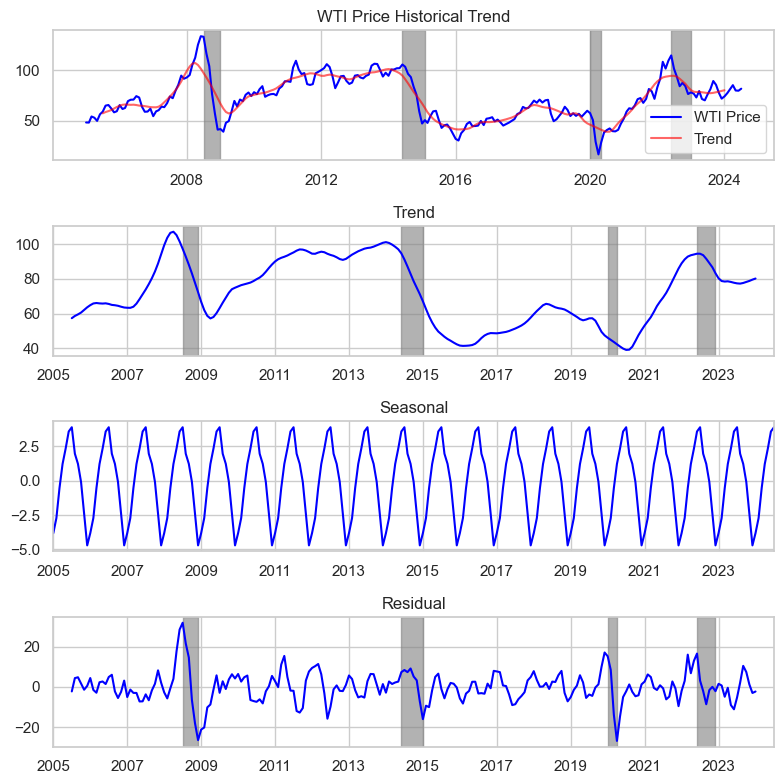

In [7]:
def analyze_time_series():
    # Create figure with subplots - one larger for WTI+Trend, three smaller for decomposition
    fig = plt.figure(figsize=(8, 8))
    
    # Seasonal Decomposition
    decomposition = seasonal_decompose(df['wti'], period=12)
    
    # Create main plot for WTI and Trend
    ax_main = plt.subplot2grid((4, 1), (0, 0), rowspan=1)
    ax_main.plot(df.index, df['wti'], label='WTI Price', color='blue')
    ax_main.plot(decomposition.trend, label='Trend', color='red', alpha=0.6)
    
    # Add crash period highlights
    # 2008 July to December
    ax_main.axvspan('2008-07-01', '2008-12-31', color='gray', alpha=0.6)
    # 2014 June to 2015 January
    ax_main.axvspan('2014-06-01', '2015-01-31', color='gray', alpha=0.6)
    # 2020 January to April
    ax_main.axvspan('2020-01-01', '2020-04-30', color='gray', alpha=0.6)
    # 2022 June to December
    ax_main.axvspan('2022-06-01', '2022-12-31', color='gray', alpha=0.6)
    
    ax_main.set_title('WTI Price Historical Trend')
    ax_main.legend()
    ax_main.grid(True)
    
    # Create three subplots for decomposition
    # Trend plot
    ax1 = plt.subplot2grid((4, 1), (1, 0))
    decomposition.trend.plot(ax=ax1, color='blue')
    # Add crash period highlights to trend plot
    ax1.axvspan('2008-07-01', '2008-12-31', color='gray', alpha=0.6)
    ax1.axvspan('2014-06-01', '2015-01-31', color='gray', alpha=0.6)
    ax1.axvspan('2020-01-01', '2020-04-30', color='gray', alpha=0.6)
    ax1.axvspan('2022-06-01', '2022-12-31', color='gray', alpha=0.6)
    ax1.set_title('Trend')
    ax1.set_xlabel('')
    ax1.grid(True)
    
    # Seasonal plot
    ax2 = plt.subplot2grid((4, 1), (2, 0))
    decomposition.seasonal.plot(ax=ax2, color='blue')
    ax2.set_title('Seasonal')
    ax2.set_xlabel('')
    ax2.grid(True)
    
    # Residual plot
    ax3 = plt.subplot2grid((4, 1), (3, 0))
    decomposition.resid.plot(ax=ax3, color='blue')
    # Add crash period highlights to residual plot
    ax3.axvspan('2008-07-01', '2008-12-31', color='gray', alpha=0.6)
    ax3.axvspan('2014-06-01', '2015-01-31', color='gray', alpha=0.6)
    ax3.axvspan('2020-01-01', '2020-04-30', color='gray', alpha=0.6)
    ax3.axvspan('2022-06-01', '2022-12-31', color='gray', alpha=0.6)
    ax3.set_title('Residual')
    ax3.set_xlabel('')  # Remove 'date' label
    ax3.grid(True)
    
    # Adjust layout to remove spaces between plots
    plt.subplots_adjust(hspace=0.1)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

# Run analyses
print("Running Time Series Analysis...")
analyze_time_series()

Insight -

Predictable Patterns:
- Oil prices follow a clear yearly cycle (seasonal ups and downs)
- After big crashes, prices typically take 1-2 years to recover
- Major price changes rarely happen suddenly - there's usually a build-up

Market Behavior:
- Grey shaded areas on the charts are Major Market Disruptions
- Big price drops (like 2008, 2015, 2020) happen about every 5-7 years
- When prices are too stable for too long, it often signals a big change coming

Useful for Predictions:
- The seasonal pattern is super reliable - good for short-term forecasting
- Price trends tend to continue for several years before reversing
- Extreme prices (either high or low) usually don't last more than 2-3 years

Main Takeaway: While we can't predict exact prices, these patterns help us understand when markets might be due for a change - especially useful for planning and risk management.

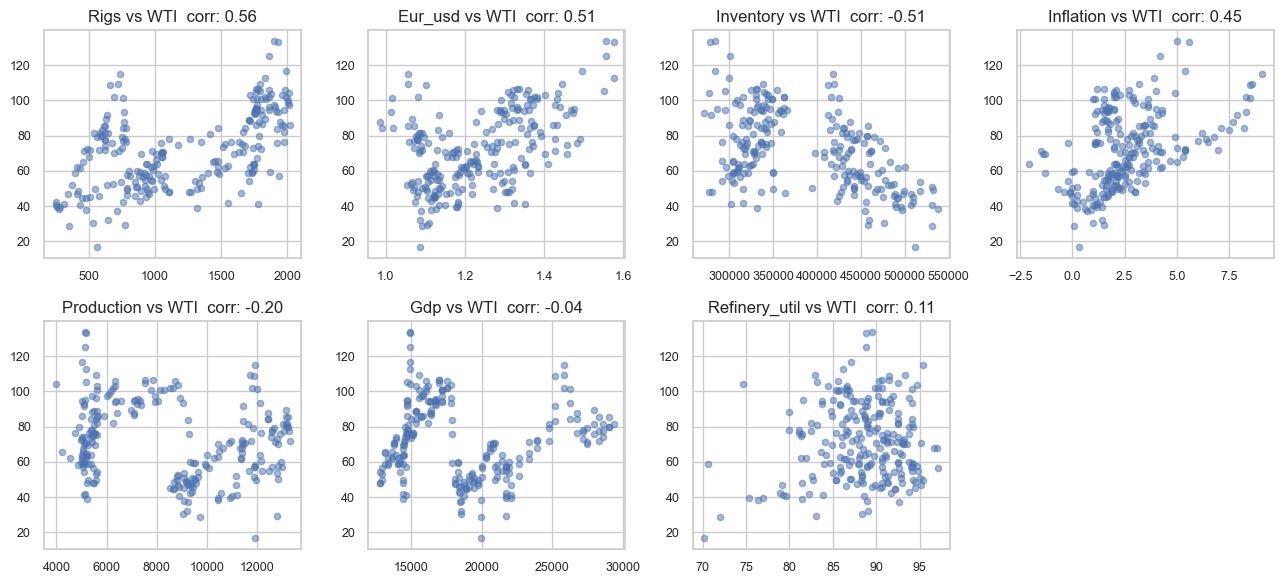

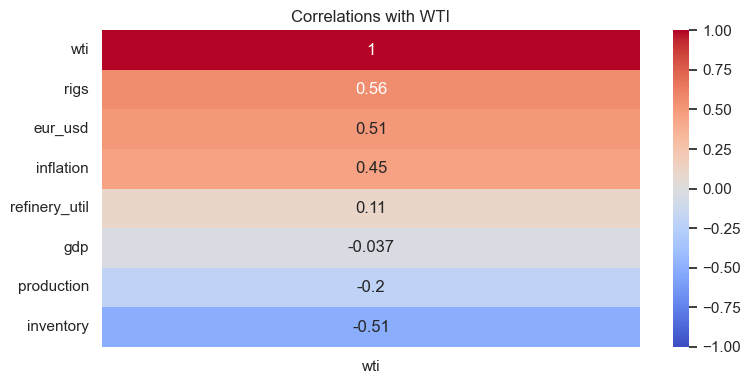

In [8]:
# Variables to compare with WTI
variables = ['rigs', 'eur_usd', 'inventory', 'inflation', 'production', 'gdp','refinery_util']

# Create figure with subplots - one row, more compact
fig, axes = plt.subplots(2, 4, figsize=(13, 6))
axes = axes.ravel()  # Flatten axes array for easier iteration

# Create correlation plots
for i, var in enumerate(variables):
    ax = axes[i]
    ax.scatter(df[var], df['wti'], alpha=0.5, s=20)
    
    # Calculate correlation coefficient
    corr = df[var].corr(df['wti'])
    ax.set_title(f'{var.capitalize()} vs WTI  corr: {corr:.2f}')
    
    # Make axis labels smaller and rotate x-axis labels
    ax.tick_params(axis='both', labelsize=9)  # Reduce font size of both x and y axis labels

# Remove the last empty subplot
if len(variables) < 8:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Create correlation heatmap specifically for WTI correlations
correlations = df[variables + ['wti']].corr()['wti'].sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlations with WTI')
plt.tight_layout()
plt.show()

Insight - 

- The patterns suggest that WTI prices are most strongly influenced by immediate market factors (rigs, inventory) rather than broader economic indicators (GDP, inflation)

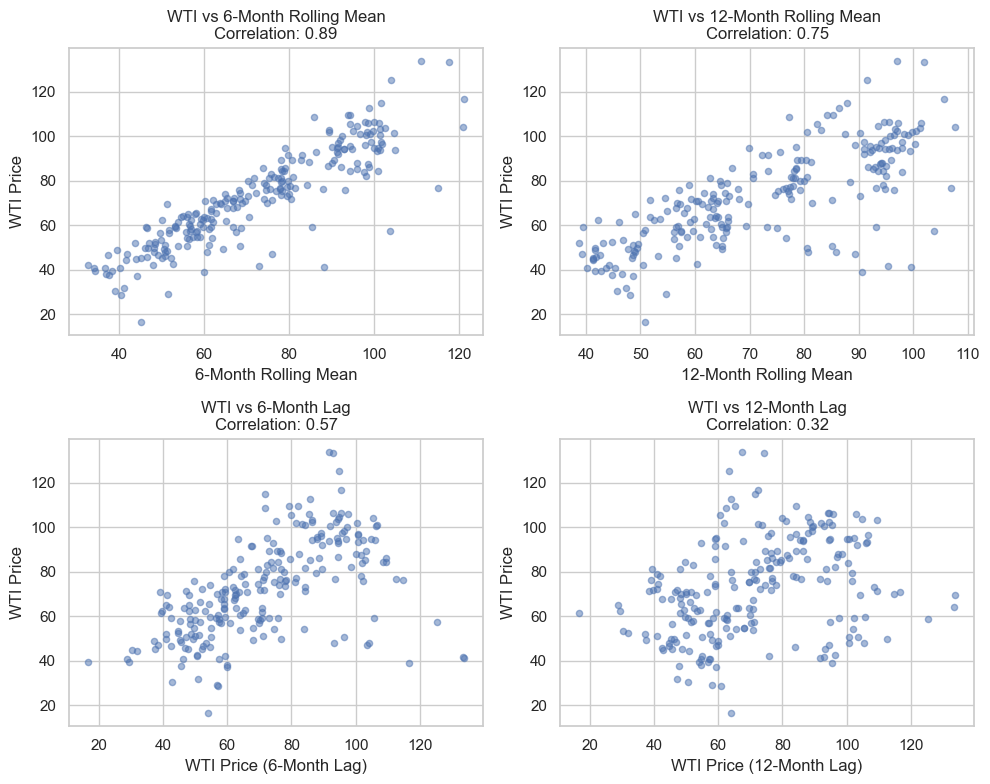

In [9]:
# Calculate rolling means
df['Rolling_mean_6m'] = df['wti'].rolling(window=6).mean()
df['Rolling_mean_12m'] = df['wti'].rolling(window=12).mean()

# Calculate lags
df['wti_lag6'] = df['wti'].shift(6)
df['wti_lag12'] = df['wti'].shift(12)

# Create figure with subplots for rolling means and lags
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot WTI vs 6-month rolling mean
ax1.scatter(df['Rolling_mean_6m'], df['wti'], alpha=0.5, s=20)
corr_6m = df['Rolling_mean_6m'].corr(df['wti'])
ax1.set_title(f'WTI vs 6-Month Rolling Mean\nCorrelation: {corr_6m:.2f}')
ax1.set_xlabel('6-Month Rolling Mean')
ax1.set_ylabel('WTI Price')

# Plot WTI vs 12-month rolling mean
ax2.scatter(df['Rolling_mean_12m'], df['wti'], alpha=0.5, s=20)
corr_12m = df['Rolling_mean_12m'].corr(df['wti'])
ax2.set_title(f'WTI vs 12-Month Rolling Mean\nCorrelation: {corr_12m:.2f}')
ax2.set_xlabel('12-Month Rolling Mean')
ax2.set_ylabel('WTI Price')

# Plot WTI vs 6-month lag
ax3.scatter(df['wti_lag6'], df['wti'], alpha=0.5, s=20)
corr_lag3 = df['wti_lag6'].corr(df['wti'])
ax3.set_title(f'WTI vs 6-Month Lag\nCorrelation: {corr_lag3:.2f}')
ax3.set_xlabel('WTI Price (6-Month Lag)')
ax3.set_ylabel('WTI Price')

# Plot WTI vs 12-month lag
ax4.scatter(df['wti_lag12'], df['wti'], alpha=0.5, s=20)
corr_lag6 = df['wti_lag12'].corr(df['wti'])
ax4.set_title(f'WTI vs 12-Month Lag\nCorrelation: {corr_lag6:.2f}')
ax4.set_xlabel('WTI Price (12-Month Lag)')
ax4.set_ylabel('WTI Price')

plt.tight_layout()
plt.show()

Insight - 

- 6, 12 month Rolling means and 6 month Lag has strong correlation with WTI price. They capture price momentum and trends. 
- The rolling means help smooth out short-term price jumps
- The lag helps capture price patterns over time

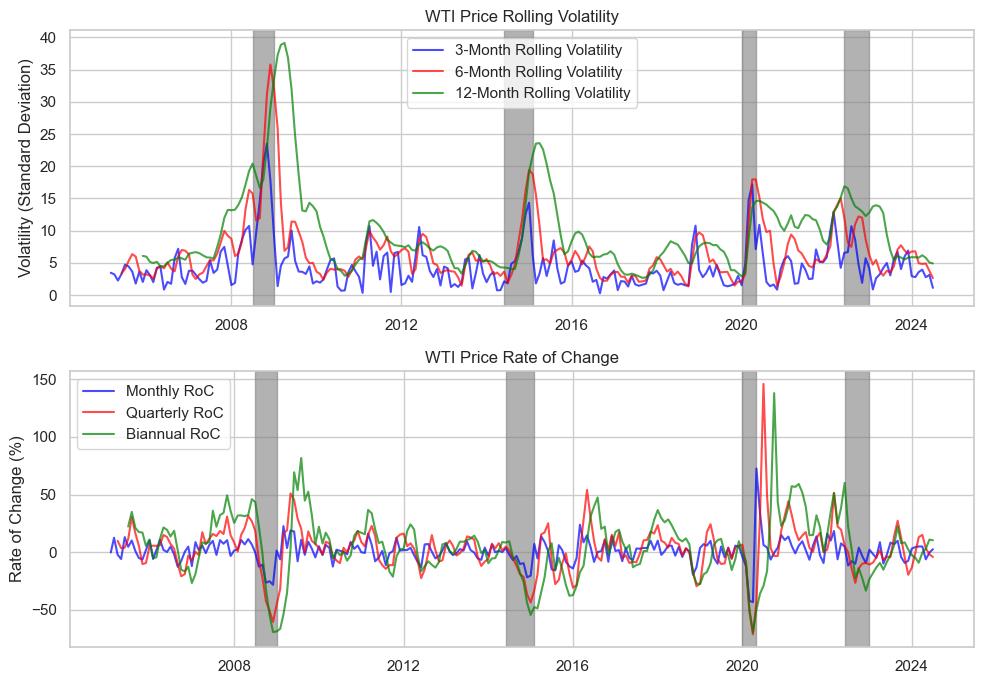

In [10]:
# Calculate rolling volatilities
windows = [3, 6, 12]  # 3-month, 6-month, and 12-month windows

# Calculate using 'wti' column
for window in windows:
    df[f'volatility_{window}m'] = df['wti'].rolling(window).std()

# Calculate rates of change
df['monthly_roc'] = df['wti'].pct_change(periods=1) * 100
df['quarterly_roc'] = df['wti'].pct_change(periods=3) * 100
df['biannual_roc'] = df['wti'].pct_change(periods=6) * 100

# Create the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Plot rolling volatilities
colors = ['blue', 'red', 'green']
for window, color in zip(windows, colors):
    ax1.plot(df.index, df[f'volatility_{window}m'],
             label=f'{window}-Month Rolling Volatility',
             color=color, alpha=0.7)

# Add crash period highlights
crash_periods = [
    ('2008-07-01', '2008-12-31'),
    ('2014-06-01', '2015-01-31'),
    ('2020-01-01', '2020-04-30'),
    ('2022-06-01', '2022-12-31')
]

for start, end in crash_periods:
    ax1.axvspan(start, end, color='gray', alpha=0.6)

ax1.set_title('WTI Price Rolling Volatility')
ax1.set_ylabel('Volatility (Standard Deviation)')
ax1.legend()
ax1.grid(True)

# Plot rates of change
ax2.plot(df.index, df['monthly_roc'], label='Monthly RoC', color='blue', alpha=0.7)
ax2.plot(df.index, df['quarterly_roc'], label='Quarterly RoC', color='red', alpha=0.7)
ax2.plot(df.index, df['biannual_roc'], label='Biannual RoC', color='green', alpha=0.7)

for start, end in crash_periods:
    ax2.axvspan(start, end, color='gray', alpha=0.6)

ax2.set_title('WTI Price Rate of Change')
ax2.set_ylabel('Rate of Change (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Insight: 
- WTI price Rolling Volatility and Rate of Change suggest, that oil markets are generally stable, but highly susceptible to global economic shocks and geopolitical events.


=== Feature Outlier Summary ===
----------------------------------------
Feature              Outliers  
----------------------------------------
rigs                 0         
eur_usd              0         
inventory            0         
inflation            4         
production           0         
gdp                  0         
refinery_util        3         
Rolling_mean_6m      0         
Rolling_mean_12m     0         
wti_lag6             0         


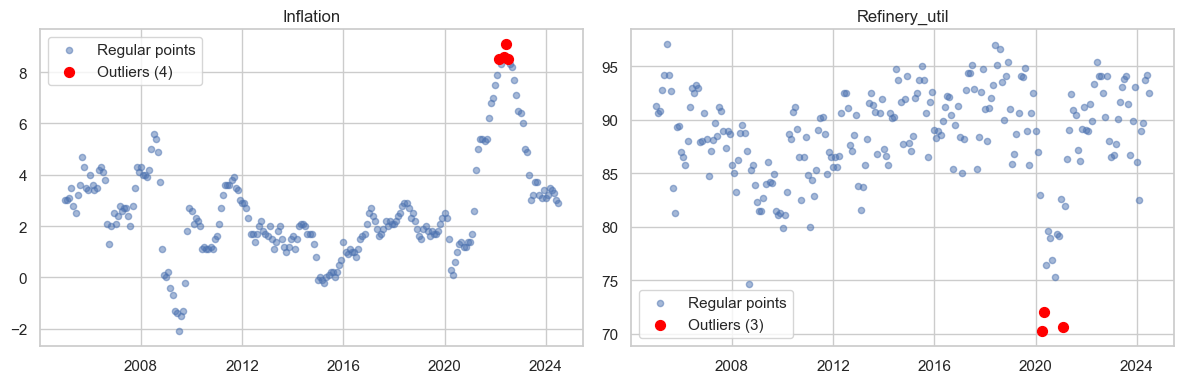

In [11]:
def check_feature_health(df):
    # Features to analyze
    features = ['rigs', 'eur_usd', 'inventory', 'inflation', 'production', 
                'gdp', 'refinery_util', 'Rolling_mean_6m', 'Rolling_mean_12m', 'wti_lag6']
    
    results = {}
    
    for feature in features:
        # Skip if feature doesn't exist in dataframe
        if feature not in df.columns:
            continue
            
        feature_stats = {}
        
        # We only need mean and std for Z-score calculation
        feature_mean = df[feature].mean()
        feature_std = df[feature].std()
        
        # Calculate Z-scores using pre-calculated mean and std
        z_scores = (df[feature] - feature_mean) / feature_std
        
        # Identify outliers (Z-score > 3)
        outliers = df[abs(z_scores) > 3]
        feature_stats['outlier_count'] = len(outliers)
        feature_stats['outlier_percentage'] = (len(outliers) / len(df)) * 100
        
        # Store outlier dates and values
        if len(outliers) > 0:
            feature_stats['outliers'] = {
                'dates': outliers.index.tolist(),
                'values': outliers[feature].tolist(),
                'z_scores': z_scores[abs(z_scores) > 3].tolist()
            }
        
        results[feature] = feature_stats
    
    return results

def print_health_report(results):
    print("\n=== Feature Outlier Summary ===")
    print("-" * 40)
    print(f"{'Feature':<20} {'Outliers':<10}")
    print("-" * 40)
    
    for feature, stats in results.items():
        print(f"{feature:<20} {stats['outlier_count']:<10}")

def plot_outliers(df, results):
    # Filter features with outliers
    features_with_outliers = {k: v for k, v in results.items() if v['outlier_count'] > 0}
    
    if not features_with_outliers:
        print("No outliers found in any feature.")
        return
        
    # Calculate number of features to plot
    n_features = len(features_with_outliers)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    # Convert axes to array if single row
    if n_rows == 1:
        axes = [axes] if n_features == 1 else axes
    axes = axes.ravel()
    
    for idx, (feature, stats) in enumerate(features_with_outliers.items()):
        ax = axes[idx]
        
        # Plot regular points
        ax.scatter(df.index, df[feature], alpha=0.5, s=20, label='Regular points')
        
        # Plot outliers
        outlier_dates = stats['outliers']['dates']
        outlier_values = stats['outliers']['values']
        ax.scatter(outlier_dates, outlier_values, color='red', s=50, 
                  label=f'Outliers ({stats["outlier_count"]})', zorder=5)
        
        ax.set_title(f'{feature.capitalize()}')
        ax.tick_params(axis='x', rotation=0)
        ax.legend()
        
    # Remove any empty subplots
    if len(features_with_outliers) < len(axes):
        for idx in range(len(features_with_outliers), len(axes)):
            fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Example usage:
results = check_feature_health(df)
print_health_report(results)
plot_outliers(df, results)

Insights -
- 2022 inflation spike (~8%): Caused by Federal Reserve's aggressive QE policy post-COVID
- 2022 refinery drops (~70%): Result of COVID lockdowns reducing operations

Will keep this outliers, because they are represent real market disruptions

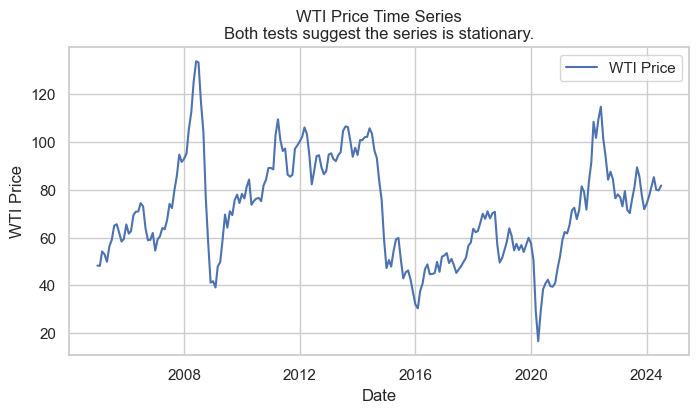

,Test,Statistic,p-value,Interpretation
0,ADF,-3.3954,0.0111,Stationary
1,KPSS,0.2611,0.1000,Trend Stationary


In [12]:
def test_stationarity(df):

    results = {}
    
    # Perform ADF test
    adf_result = adfuller(df['wti'].dropna())
    results['adf'] = {
        'statistic': adf_result[0],
        'p_value': adf_result[1],
        'critical_values': adf_result[4],
        'is_stationary': adf_result[1] < 0.05
    }
    
    # Perform KPSS test
    kpss_result = kpss(df['wti'].dropna(), regression='c', nlags='auto')
    results['kpss'] = {
        'statistic': kpss_result[0],
        'p_value': kpss_result[1],
        'critical_values': kpss_result[3],
        'is_trend_stationary': kpss_result[1] >= 0.05
    }
    
    # Overall interpretation
    if results['adf']['is_stationary'] and results['kpss']['is_trend_stationary']:
        results['overall_interpretation'] = "Both tests suggest the series is stationary."
    elif not results['adf']['is_stationary'] and not results['kpss']['is_trend_stationary']:
        results['overall_interpretation'] = "Both tests suggest the series is non-stationary."
    elif results['adf']['is_stationary'] and not results['kpss']['is_trend_stationary']:
        results['overall_interpretation'] = "Tests give conflicting results. This might indicate complex dynamics."
    else:
        results['overall_interpretation'] = "Neither test found clear evidence of non-stationarity."
    
    return results

# Example usage:
stationarity_results = test_stationarity(df)

# Plot time series with stationarity test results
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['wti'], label='WTI Price')
plt.title(f"WTI Price Time Series\n{stationarity_results['overall_interpretation']}")
plt.xlabel('Date')
plt.ylabel('WTI Price')
plt.legend()
plt.grid(True)
plt.show()

# Create summary table using Pandas
summary_data = {
    'Test': ['ADF', 'KPSS'],
    'Statistic': [
        f"{stationarity_results['adf']['statistic']:.4f}",
        f"{stationarity_results['kpss']['statistic']:.4f}"
    ],
    'p-value': [
        f"{stationarity_results['adf']['p_value']:.4f}",
        f"{stationarity_results['kpss']['p_value']:.4f}"
    ],
    'Interpretation': [
        'Stationary' if stationarity_results['adf']['is_stationary'] else 'Non-stationary',
        'Trend Stationary' if stationarity_results['kpss']['is_trend_stationary'] else 'Not Trend Stationary'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

Insights - 
- The WTI oil price time series from 2006-2022 shows significant volatility, with notable extreme events during 2008 (financial crisis), 2016 (oil price crisic), 2020 (COVID), 2022 (Recession fear)
- But ADF and KPSS tests suggest, the WTI price series is stationary, meaning it has consistent statistical properties over time (stable mean and variance) despite its visible fluctuations

This is important for time series analysis as it suggests we can model the series without further transformations. 


Actions - 
- Do not use GDP and refinery utilization columns, because of week corelations with WTI price
- Add 6-12 month rolling means and 6 month lag as feature selection
- Keep fundamental columns (eur_usd, inflation, inventory, production, rigs, wti)